<a id='intro'></a>
## Simulation of a Single Spectrum

We will simulate the energy spectrum of 3FHL J1230.8+1223 from the Fermi-LAT 3FHL source catalog considering the Dominguez EBL absorption spectral model. To do a simulation, we need to define the observational parameters like
the livetime, the offset, the assumed integration radius, the energy
range to perform the simulation for and the choice of spectral model. We
then use an in-memory observation which is convolved with the IRFs to
get the predicted number of counts. This is Poission fluctuated using
the `fake()` to get the simulated counts for each observation.

<a id='indice'></a>
### Indice
[Step 0.0:  Setting the Engine Tools](#step0)<br>
$\;\;\;\;\;$[Step 0.1:  Importing the Python Necessary Tools](#step0.1)<br>
$\;\;\;\;\;$[Step 0.2:  Defining Functions](#step0.2)<br>
[Step 1.0: Source Information](#step1)<br>
[Step 2.0: Creates the Observation](#step2)<br>
[Step 3.0: Defining the Skymodel](#step3)<br>
[Step 4.0: Simulating the Spectrum](#step4)<br>
$\;\;\;\;\;$[Step 4.1: Defines the geometry](#step4.1)<br> 
$\;\;\;\;\;$[Step 4.2: Setting the Model on the Dataset](#step4.2)<br> 
[Step 5.0: On-Off Analysis](#step5)<br>
$\;\;\;\;\;$[Step 5.1: Simulating the Observations](#step5.1)<br>
$\;\;\;\;\;$[Step 5.2: Plotting Counts, Excess and Significance](#step5.2)<br>
$\;\;\;\;\;$[Step 5.3: Computing the Sensitivity](#step5.3)<br>
$\;\;\;\;\;$[Step 5.4 Computing the Flux Points](#step5.4)<br>

<a id='step0'></a>
## Step 0.0:  Setting the Engine Tools

<a id='step0.1'></a>
### Step 0.1: Importing the Python Necessary Tools

In [1]:
import gammapy
from astropy import units as u
import numpy as np
from astropy.io import ascii
import collections
import sys, os
import matplotlib.pyplot as plt

from gammapy.catalog import SourceCatalog3FHL
from gammapy.makers import SpectrumDatasetMaker, SafeMaskMaker, ReflectedRegionsBackgroundMaker
from gammapy.modeling import Fit
from gammapy.data import Observation, Observations, observatory_locations
from gammapy.datasets import SpectrumDatasetOnOff, SpectrumDataset, Datasets
from gammapy.irf import load_cta_irfs
from gammapy.maps import MapAxis, RegionGeom

from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel,
    Models,
    PowerLawSpectralModel,
    SkyModel,
)

from gammapy.irf import EffectiveAreaTable2D

from numpy.random import RandomState

from scipy.stats import chi2, norm

from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators import FluxPoints
from gammapy.datasets import FluxPointsDataset

# astropy imports
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from astropy.io import fits
from astropy.table import Table, Column

from gammapy.estimators import SensitivityEstimator

# astropy affiliated packages imports
from regions import CircleSkyRegion

from gammapy.stats import WStatCountsStatistic
from gammapy.stats import CashCountsStatistic
from scipy.stats import sem
from gammapy.maps import Map
from regions import PointSkyRegion

import math

from pathlib import Path

<a id='step0.2'></a>
### Step 0.2: Defining Functions

In [2]:
def mkdir_base_child(base_dir, child_dir):
    '''Creates a directory: base_dir/child_dir and returs the path 
    mkdir_base_child(base_dir, child_dir)
    >>> path_child
    '''
    path_base = Path(f"{base_dir}")
    path_base.mkdir(exist_ok=True)

    path_child = Path(f"{path_base}/{child_dir}")
    path_child.mkdir(exist_ok=True)
    
    return path_child

In [3]:
def plt_savefig(path_child, child_name):
    ''' Saves figures (.png and .pdf) in the path_child directoty    
    plt_savefig(path_child, child_name)
    >>> plt.savefig(file, bbox_inches='tight')
    '''
    formats_file = [".png", ".pdf"]
    for format_file in formats_file: 
        file = path_child / f'{src_id}_{child_name}_{ebl_ref}{format_file}'
        plt.savefig(file, bbox_inches='tight')


___

🔝 [Back to Top](#intro)<br>

<a id='step1'></a>
## Step 1.0:  Source Information

In [4]:
SourceCatalog = SourceCatalog3FHL() # Fermi-LAT 3FHL source catalog
# display(SourceCatalog.table)

In [5]:
src_name = "3FHL J1230.8+1223"  # Official source name 3FHL JHHMM.m+DDMM

In [6]:
src_data = SourceCatalog[src_name].data
# src_data

In [7]:
src_id  = src_data["ASSOC1"].replace(" ", "") # Name of identified or likely associated source

src_ra  = src_data["RAJ2000"]  # Right Ascension (deg)
src_de  = src_data["DEJ2000"]  # Declination (deg)

src_red = src_data["Redshift"] # Redshift of counterpart, if known

In [8]:
type(src_red)

numpy.float32

In [9]:
print(f"{src_id} Source Information:")
print(f"(RAJ2000, DEJ2000) = ({src_ra:.3f}, {src_de:.3f}); Redshift = {src_red:.3f}" )

M87 Source Information:
(RAJ2000, DEJ2000) = (187.703 deg, 12.389 deg); Redshift = 0.004


___

🔝 [Back to Top](#intro)<br>

<a id='step2'></a>
## Step 2.0:  Creates the Observation

Define the source position:

In [10]:
frame  = "icrs" # International Celestial Reference System (ICRS)
unit   = "deg"  # Degrees units

In [11]:
src_pos = SkyCoord(src_ra, src_de, unit=unit, frame=frame) # Source Position

Define the observation parameters (typically the observation duration and the pointing position):


In [12]:
livetime = 50 * u.h # Livetime exposure of the simulated observation

offset = 0.5 * u.deg # Pointing position  offset
pointing = SkyCoord(src_pos.ra, src_pos.dec + offset, unit=unit, frame=frame)
# print(pointing)

Load the IRFs:

In [15]:
# In this simulation, we use the CTA-1DC irfs shipped with gammapy
base_name = '/home/born-again/Documents/GitHub/gammapy/gammapy-notebooks/0.20.1/tutorials/data/caldb/data/cta/prod3b-v2/bcf'
irfs = load_cta_irfs(base_name + '/North_z20_N_0.5h/irf_file.fits')

/tmp/ipykernel_91889/4137751766.py:3: GammapyDeprecationWarning: The load_cta_irfs function is deprecated and may be removed in a future version.
        Use load_irf_dict_from_file instead.
  irfs = load_cta_irfs(base_name + '/North_z20_N_0.5h/irf_file.fits')
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Creates a observation:

In [16]:
location = observatory_locations["cta_north"]
obs = Observation.create(
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
    location=location,
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51546.08
	duration          : 180000.00 s
	pointing (icrs)   : 187.7 deg, 12.9 deg

	deadtime fraction : 0.0%



/home/born-again/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


___

🔝 [Back to Top](#intro)<br>

<a id='step3'></a>
## Step 3.0:  Defining the Skymodel
Define spectral model:

In [17]:
# A simple Power Law
index=2.24
amplitude=6.47e-13 * u.Unit("cm-2 s-1 TeV-1")
reference=0.1 * u.TeV
    
pwl = PowerLawSpectralModel(
    index=index,
    amplitude=amplitude,
    reference=reference,
)
# print(pwl)

Define absorption model:

In [18]:
ebl_models = ['franceschini', 'dominguez', 'finke'] # Available models in gammapy-data:{'franceschini', 'dominguez', 'finke'}

ebl_ref = ebl_models[1] # dominguez

absorption = EBLAbsorptionNormSpectralModel.read_builtin(
    reference = ebl_ref, 
    redshift=src_red
)
print(absorption)

EBLAbsorptionNormSpectralModel

  type      name      value    unit   error   min max frozen is_norm link
-------- ---------- ---------- ---- --------- --- --- ------ ------- ----
spectral alpha_norm 1.0000e+00      0.000e+00 nan nan   True   False     
spectral   redshift 4.2830e-03      0.000e+00 nan nan   True   False     


The compound spectral model:

In [19]:
absspecmodel = pwl * absorption # CompoundSpectralModel
# print(absspecmodel)

Setting the sky model used in the dataset:

In [20]:
skymodel = SkyModel(
    spectral_model=absspecmodel, 
    name="model_simu"
)
# print(skymodel)

___

🔝 [Back to Top](#intro)<br>

<a id='step4'></a>
## Step 4.0:  Simulating the Spectrum
<a id='step4.1'></a>
### Step 4.1: Defines the geometry

In [21]:
# Defines the energy range
emin = 25 * u.GeV   # Minimum energy
emax = 100. * u.TeV # Maximum energy

In [22]:
# Reconstructed energy axis
energy_reco = MapAxis.from_energy_bounds(
    emin, 
    emax, 
    nbin=5, 
    per_decade=True, 
    name="energy"
)
# print(energy_reco)

In [23]:
# Defines the on region:
on_region_radius = Angle("0.11 deg")

on_region = CircleSkyRegion(
    center=src_pos, 
    radius=on_region_radius
)
# print(on_region)

In [24]:
#Defines the geometry:
geom = RegionGeom.create(
    region=on_region, 
    axes=[energy_reco]
)

<a id='step4.2'></a>
### Step 4.2: Setting the Model on the Dataset

In [25]:
# Defines the true energy axis:
# true energy axis should be wider than reco energy axis
energy_true = MapAxis.from_energy_bounds(
    0.3*emin, 
    3*emax, 
    nbin=8, 
    per_decade=True, 
    name="energy_true"
)
# print(energy_true)

In [26]:
# Create a MapDataset object with zero filled maps.
dataset_empty = SpectrumDataset.create(
    geom=geom, 
    energy_axis_true=energy_true,
    name="obs-0"
)

In [27]:
# Make spectrum for a single IACT observation:
# The irfs and background are computed at a single fixed offset, which is recommended only for point-sources.
maker = SpectrumDatasetMaker(
    containment_correction=True, # Apply containment correction for point sources and circular on regions.
    selection=["edisp", "background", "exposure"] # Selecting which maps to make
)
safe_maker = SafeMaskMaker(methods=["bkg-peak"]) # Make safe data range mask for a given observation.

In [28]:
# Make map dataset:
dataset = maker.run(dataset_empty, obs) 
dataset = safe_maker.run(dataset, obs)

In [29]:
# Set the model on the dataset, and fake
dataset.models = skymodel
dataset.fake(random_state=42)
# print(dataset)

You can see that background counts are now simulated.

___

🔝 [Back to Top](#intro)<br>

<a id='step5'></a>
### Step 5.0: On-Off Analysis

To do an on off spectral analysis, which is the usual science case, the
standard would be to use `SpectrumDatasetOnOff`, which uses the
acceptance to fake off-counts

<a id='step5.1'></a>
### Step 5.1: Simulating the Observations

In [30]:
# Spectrum dataset for on-off likelihood fitting.
dataset_onoff = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, 
    acceptance=1, 
    acceptance_off=5
)

# Simulate fake counts (on and off) for the current model and reduced IRFs.
dataset_onoff.fake(
    random_state='random-seed', 
    npred_background=dataset.npred_background()
)

# print(dataset_onoff)

In [31]:
# Class to compute statistics for Poisson distributed variable with unknown background.
significance = WStatCountsStatistic(
    n_on=sum(dataset_onoff.counts.data), 
    n_off=sum(dataset_onoff.counts_off.data), 
    alpha=0.2).sqrt_ts
# print(significance)

In [32]:
n_obs = 10 # We simulate each observation n_obs times, to randomize the renortets

In [33]:
datasets = Datasets()

for idx in range(n_obs):
    dataset_onoff.fake(
        random_state=idx, 
        npred_background=dataset.npred_background()
    )
    dataset_fake = dataset_onoff.copy(name=f"obs-{idx}")
    dataset_fake.meta_table["OBS_ID"] = [idx]
    datasets.append(dataset_fake)

table = datasets.info_table()
# print(table)

<a id='step5.2'></a>
### Step 5.2: Plotting Counts, Excess and Significance

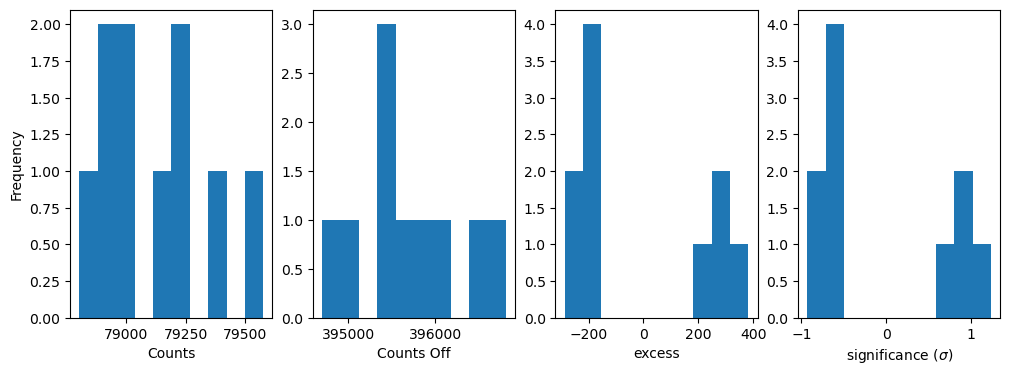

In [34]:
fix, axes = plt.subplots(1, 4, figsize=(12, 4))
axes[0].hist(table["counts"])
axes[0].set_xlabel("Counts")
axes[0].set_ylabel("Frequency");

axes[1].hist(table["counts_off"])
axes[1].set_xlabel("Counts Off");

axes[2].hist(table["excess"])
axes[2].set_xlabel("excess");

axes[3].hist(table["sqrt_ts"])
axes[3].set_xlabel(r"significance ($\sigma$)");

path_counts = mkdir_base_child("analysis", "counts")

plt_savefig(path_counts, "counts")

<a id='step5.3'></a>
### Step 5.3: Computing the Sensitivity

  energy    e_ref     e_min     e_max   ...  excess background  criterion  
   TeV       TeV       TeV       TeV    ...                                
--------- --------- --------- --------- ... ------- ---------- ------------
0.0310979 0.0310979     0.025 0.0386832 ... 2781.94    27819.4          bkg
0.0481186 0.0481186 0.0386832 0.0598555 ... 2071.62    20716.2          bkg
0.0744552 0.0744552 0.0598555 0.0926161 ... 1411.46    14114.6          bkg
 0.115207  0.115207 0.0926161  0.143307 ...  850.04     8500.4          bkg
 0.178262  0.178262  0.143307  0.221743 ...  407.74     4077.4          bkg
  0.27583   0.27583  0.221743  0.343109 ...   198.3       1983          bkg
      ...       ...       ...       ... ...     ...        ...          ...
  5.85755   5.85755   4.70896   7.28631 ... 14.4531       14.2 significance
  9.06355   9.06355   7.28631   11.2743 ... 11.9241          9 significance
  14.0243   14.0243   11.2743    17.445 ... 9.83814        5.6 significance
  21.7001   

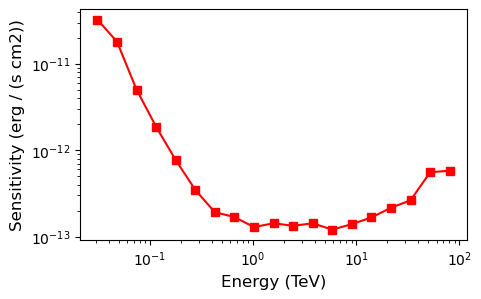

In [35]:
sensitivity_estimator = SensitivityEstimator(
    gamma_min=5, 
    n_sigma=3, 
    bkg_syst_fraction=0.10
)
sensitivity_table = sensitivity_estimator.run(dataset_onoff)
print(sensitivity_table)

# Plot the sensitivity curve
t = sensitivity_table

fix, axes = plt.subplots(figsize=(5, 3))

axes.plot(t["energy"], t["e2dnde"], "s-", color="red")
axes.loglog()

axes.set_xlabel(f"Energy ({t['energy'].unit})", size=12)
axes.set_ylabel(f"Sensitivity ({t['e2dnde'].unit})", size=12)

path_sens = mkdir_base_child("analysis", "sensitivity")

plt_savefig(path_sens, "sensitivity")

In [40]:
sensitivity_table[["energy", "e2dnde"]]

energy,e2dnde
TeV,erg / (s cm2)
float64,float64
0.0310979,3.24458e-11
0.0481186,1.80199e-11
0.0744552,5.02297e-12
0.115207,1.86464e-12
0.178262,7.68459e-13
0.27583,3.46646e-13
...,...
9.06355,1.39078e-13


<a id='step5.4'></a>
### Step 5.4:  Computing the Flux Points

We can now compute some flux points using the `~gammapy.estimators.FluxPointsEstimator`. 

Besides the list of datasets to use, we must provide it the energy intervals on which to compute flux points as well as the model component name. 

In [36]:
#Compute flux points
datasets.models = [skymodel]

fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)

# we make a copy here to compare it later
model_best_joint = skymodel.copy()

energy_edges = MapAxis.from_energy_bounds("0.1 TeV", "30 TeV", nbin=12).edges

fpe = FluxPointsEstimator(energy_edges=energy_edges, source="model_simu", selection_optional="all")
flux_points = fpe.run(datasets=datasets)

display(flux_points.to_table(sed_type="dnde", formatted=True))

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[10],float32[10],float64,bool,float64[10],bool,float64[11],float64[11]
0.115,0.093,0.143,3.754e-15,5.541e-19,nan,nan,nan,0.001,0.028,8449.871347276221 .. 8479.871492008097,0.04567958 .. 0.04567958,8.222,True,8508.0 .. 8377.0,True,0.200 .. 5.000,8.223 .. 8.223
0.178,0.143,0.222,1.187e-13,6.761e-13,nan,nan,nan,0.031,0.176,4020.557519064038 .. 4072.2245207407213,3.8608494 .. 3.8608494,8.384,True,3978.0 .. 4027.0,True,0.200 .. 5.000,8.415 .. 8.415
0.276,0.222,0.343,9.142e-14,1.881e-13,nan,nan,nan,0.237,0.487,2000.0489478481732 .. 1988.740392161454,7.481894 .. 7.481894,5.372,True,2031.0 .. 1980.0,True,0.200 .. 5.000,5.609 .. 5.609
0.531,0.343,0.821,-1.039e-14,1.655e-14,nan,nan,nan,0.389,-0.624,1420.9605268176126 .. 1425.6004594988374,-6.0910993 .. -6.0910993,13.703,True,1466.0 .. 1410.0,True,0.200 .. 5.000,14.092 .. 14.092
1.022,0.821,1.271,4.525e-15,6.762e-15,nan,nan,nan,0.460,0.678,253.7560559480496 .. 251.7220614010277,3.6789782 .. 3.6789782,1.605,True,244.0 .. 256.0,True,0.200 .. 5.000,2.065 .. 2.062
1.581,1.271,1.967,2.223e-15,2.978e-15,nan,nan,nan,0.563,0.750,143.77679101385618 .. 146.93632089977007,3.0943704 .. 3.0943704,14.440,True,135.0 .. 140.0,True,0.200 .. 5.000,15.003 .. 14.993
2.447,1.967,3.043,-2.509e-16,1.207e-15,nan,nan,nan,0.043,-0.206,68.99005346609826 .. 77.32162878070228,-0.6119535 .. -0.6119535,12.798,True,69.0 .. 76.0,True,0.200 .. 5.000,12.841 .. 12.852
3.786,3.043,4.709,-3.864e-16,4.388e-16,nan,nan,nan,0.759,-0.871,29.149734634088684 .. 42.11967985902176,-1.7466214 .. -1.7466214,13.952,True,23.0 .. 53.0,True,0.200 .. 5.000,14.719 .. 14.898


In [37]:
display(flux_points.to_table())

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,stat_scan,norm_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[10],float32[10],float64,bool,float64[10],bool,float64[11],float64[11]
0.11520660415588542,0.0926160645759766,0.14330733768376508,3.9179509196307457e-19,2.0283394245511335e-20,2.4265159584631285e-21,9582.56778506148,1.4142135623730951,nan,nan,nan,0.0008011511527001858,0.02830461362923341,8449.871347276221 .. 8479.871492008097,0.04567958 .. 0.04567958,8.222461080760695,True,8508.0 .. 8377.0,True,8.223262214916758 .. 8.223261812934652,0.2 .. 4.999999999999999
0.17826228960121232,0.14330733768376508,0.22174331340932085,5.847079196552556e-19,4.682967378770695e-20,8.668046713405079e-21,202925.85126137114,1156255.6825209537,nan,nan,nan,0.030813385266810656,0.17553741842356763,4020.557519064038 .. 4072.2245207407213,3.8608494 .. 3.8608494,8.38417287968332,True,3978.0 .. 4027.0,True,8.41498620423954 .. 8.414984746021219,0.2 .. 4.999999999999999
0.2758300544200454,0.22174331340932085,0.3431094167016588,8.70412987339792e-19,1.0785248822161783e-19,3.0886128347931164e-20,105035.78573679455,216113.31354277872,nan,nan,nan,0.23712536547100171,0.48695519862817127,2000.0489478481732 .. 1988.740392161454,7.481894 .. 7.481894,5.371716365596512,True,2031.0 .. 1980.0,True,5.608840829343535 .. 5.6088191869203,0.2 .. 4.999999999999999
0.5309024656452349,0.3431094167016588,0.8214797213603471,1.5690307075678243e-18,8.124322565602142e-19,4.969126241524602e-19,-6625.057242501978,10544.989070147205,nan,nan,nan,0.38916725662420504,-0.6238327152564259,1420.9605268176126 .. 1425.6004594988374,-6.0910993 .. -6.0910993,13.70260546982172,True,1466.0 .. 1410.0,True,14.091796365843038 .. 14.092363926276448,0.2 .. 4.999999999999999
1.0218517652864825,0.8214797213603471,1.2710977557546597,2.8084447993614583e-18,1.2882452685728551e-18,1.3663382014794198e-18,1611.142554291624,2407.905295452538,nan,nan,nan,0.45960209033364663,0.6779395919502317,253.7560559480496 .. 251.7220614010277,3.6789782 .. 3.6789782,1.605012661220826,True,244.0 .. 256.0,True,2.06450140101515 .. 2.0617852090617816,0.2 .. 4.999999999999999
1.5811388300841898,1.2710977557546597,1.9668038816697717,4.144904599972218e-18,2.9440517431720237e-18,4.8321786559057855e-18,536.2349592819381,718.5291816672635,nan,nan,nan,0.5625936220785661,0.7500624121221954,143.77679101385618 .. 146.93632089977007,3.0943704 .. 3.0943704,14.440425474120275,True,135.0 .. 140.0,True,15.0025975685694 .. 14.992528750583006,0.2 .. 4.999999999999999
2.4465388081989654,1.9668038816697717,3.0432887568546065,6.140747561860971e-18,6.749254052929943e-18,1.7141947280040672e-17,-40.865845448310424,196.53325052912575,nan,nan,nan,0.04256844536121207,-0.20632121888262503,68.99005346609826 .. 77.32162878070228,-0.6119535 .. -0.6119535,12.798384209111646,True,69.0 .. 76.0,True,12.841372033329208 .. 12.852051241427489,0.2 .. 4.999999999999999
3.785595563233942,3.0432887568546065,4.708962873174102,9.08354936354676e-18,1.5440919754041322e-17,6.067171263509886e-17,-42.535612494713185,48.30568493095885,nan,nan,nan,0.7594931241071663,-0.8714890269574059,29.149734634088684 .. 42.11967985902176,-1.7466214 .. -1.7466214,13.952407379705164,True,23.0 .. 53.0,True,14.718965058190633 .. 14.898066743413438,0.2 .. 4.999999999999999


In [38]:
flux_points["dnde"].data[j]

NameError: name 'j' is not defined

In [ ]:
dnde

In [ ]:
e_ref = []
e_min = []
e_max = []
dnde = []
dnde_err = []
subtract_emin = []
subtract_emax = []

for j in range(len(flux_points["energy_max"].value)):
    if flux_points["dnde"].data[j] > 0:
        e_ref.append(flux_points["energy_ref"].value[j])
        e_min.append(flux_points["energy_min"].value[j])
        e_max.append(flux_points["energy_max"].value[j])
        dnde.append(flux_points["dnde"].data[j][0])
        dnde_err.append(flux_points["dnde_err"].data[j][0])
        
flux_TEV = np.hstack((dnde))#*1e+06
flux_err_TEV = np.hstack((dnde_err))#*1e+06  
energy = np.hstack((e_ref))

#print(len(energy), len(flux_TEV))
#print(energy)
#print(np.asarray(flux_TEV))
#print(np.hstack((e_ref))-np.hstack((e_min)), np.hstack((e_max))-np.hstack((e_ref)))

energy_bounds = [0.1, 50] * u.TeV
plt.figure()
absspecmodel.plot(
    energy_bounds, 
    label='intrinsic spectrum + EBL'
)

xerr = [np.hstack((e_ref))-np.hstack((e_min)), np.hstack((e_max))-np.hstack((e_ref))]
plt.errorbar(
    e_ref, 
    flux_TEV, 
    color='red', 
    marker='o', 
    xerr = xerr, 
    yerr = flux_err_TEV, 
    linestyle='', 
    label='measured spectrum')
plt.grid(which="both")
plt.ylim(1e-24, 1e-8)
plt.legend(loc="best")
plt.title("M87")

path_flux = mkdir_base_child("analysis", "flux_point")

plt_savefig(path_flux, "flux_point")

plt.savefig('./spectrum_srcM87.png', bbox_inches='tight')

plt.savefig('./M87_gammapy_flux_point.png', bbox_inches='tight')
plt.savefig('./M87_gammapy_flux_point.pdf', bbox_inches='tight')

plt.show()


___

🔝 [Back to Top](#intro)<br>